In [23]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [31]:
df = pd.read_csv('players_22.csv')
df.head()

C:\Users\Aniket\AppData\Local\Temp\ipykernel_17120\1327346208.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('players_22.csv')


,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [32]:
features = ['overall','potential','value_eur','wage_eur','age']
df = df.dropna(subset=features)
#most clustering algorithms don't work well with missing values

In [33]:
data = df[features].copy()
data

,overall,potential,value_eur,wage_eur,age
0,93,93,78000000.0,320000.0,34
1,92,92,119500000.0,270000.0,32
2,91,91,45000000.0,270000.0,36
3,91,91,129000000.0,270000.0,29
4,91,91,125500000.0,350000.0,30
...,...,...,...,...,...
19234,47,52,70000.0,1000.0,22
19235,47,59,110000.0,500.0,19
19236,47,55,100000.0,500.0,21
19237,47,60,110000.0,500.0,19


Steps
1. Scale the data - Some of the columns have value that are much larger than values in other columns. So, when we do clustering these columns with largest values will have the most importance. We don't want that. We want every column to be treated equally. So, we rescale the maximum and minimum value in each column such that all the values are in the range 1 to 10. This will ensure no column dominates the other in the clustering. 

2. Initialize random centroids 

3. Label each datapoint based on how far that datapoint is from each centroid which will give us our cluster assignment for each player. 

4. Update our centroids


5. Repeat 3 and 4 till centroids stop changing 

In [34]:
#scaling using min-max scaling 
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1

In [35]:
data.describe()

,overall,potential,value_eur,wage_eur,age
count,19165.000000,19165.000000,19165.000000,19165.000000,19165.000000
mean,4.670472,5.319998,1.131826,1.219443,4.063345
std,1.346635,1.191076,0.353229,0.501528,1.575838
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.739130,4.521739,1.021620,1.012876,2.666667
50%,4.717391,5.304348,1.044817,1.064378,4.000000
75%,5.500000,6.086957,1.092370,1.193133,5.333333
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [36]:
#initializing random centroids 
#we need to set a value for each feature
centroid = data.apply(lambda x:float(x.sample()))
#.apply method is going to iterate through each column in the data.
# x.sample() - selects a single random value from that column. 
# turn the above into a float because x.sample returns a pandas series.
centroid


overall      3.347826
potential    6.478261
value_eur    1.042497
wage_eur     1.270386
age          4.000000
dtype: float64

In [37]:
def create_centroid(data,k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x:float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids,axis=1)

In [38]:
actual_centroids = create_centroid(data,5)
actual_centroids

,0,1,2,3,4
overall,4.326087,8.043478,3.152174,6.478261,3.543478
potential,4.913043,6.282609,6.673913,6.673913,7.260870
value_eur,1.015820,1.023939,1.026259,1.008397,1.579506
wage_eur,1.005150,1.553648,1.708155,1.038627,1.038627
age,1.666667,2.666667,5.000000,2.000000,5.666667


So what this means is cluster 0 is going to have 4.326~ overall value, 4.913~ potential value and so on 

We are going to find the euclidean distance between datapoint and each cluster center. 

In [39]:
edistances = actual_centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
#centriods for cluster 0 are given by actual_centroids.iloc[:,0], which means all the rows
#and first column 

In [40]:
edistances

,0,1,2,3,4
0,12.777766,10.270131,11.355552,11.229611,11.192326
1,12.275464,9.879088,11.081900,10.752223,10.795616
2,11.611002,9.005817,9.917148,10.016469,9.721938
3,11.983015,9.720360,11.072547,10.522374,10.842811
4,13.306112,11.181298,12.286005,11.992403,12.182158
...,...,...,...,...,...
19234,4.889143,8.489036,5.915483,7.542490,6.790206
19235,3.873254,7.837396,5.287041,6.620562,6.226801
19236,4.423330,8.173058,5.552321,7.120906,6.455916
19237,3.778198,7.756388,5.151354,6.512718,6.093194


The first value in this i.e 12.777 represents the distance between the first datapoint 
and cluster 0. The second value in that same row represents the distance between the first 
datapoint and the 2nd cluster. So, we need to find the cluster that is the closest to each
datapoint

In [41]:
edistances.idxmin(axis=1)
#gives us the index of the minimum value in each row 

0        1
1        1
2        1
3        1
4        1
        ..
19234    0
19235    0
19236    0
19237    0
19238    0
Length: 19165, dtype: int64

In [42]:
#lets wrap this in a function 
def get_labels(data,actual_centroids):
    edistances = actual_centroids.apply(lambda x:np.sqrt(((data - x)**2).sum(axis=1)))
    #calculating the distance between each centroid and each datapoint 
    return edistances.idxmin(axis=1)
    #this is finding the cluster assignment for each datapoint 

In [43]:
labels = get_labels(data,actual_centroids)
#we can see how many datapoints are there in each cluster 
labels.value_counts()

0    8122
2    4627
3    2844
4    2193
1    1379
dtype: int64

Now we have assigned each sale to a cluster based on our random centroids.

We need the geometric mean to update the cluster. Geometric mean is the product of all the 
datapoint and taking the nth root of the product where n is the number of datapoints

In [44]:
data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean()))

,overall,potential,value_eur,wage_eur,age
0,3.481296,4.952658,1.033459,1.039680,2.740348
1,7.137980,7.034036,1.791347,2.163830,4.660212
2,4.588029,4.320843,1.039845,1.097609,5.243830
3,5.603654,6.641835,1.190176,1.278606,3.114208
4,5.747879,5.358812,1.085929,1.252282,6.533015


So the first value i.e 3.481~ is the geometric mean of all of the overall values for datapoints assigned to cluster 0 
The second value in that column is the geometric mean of all of the overall values for 
datapoints assigned to cluster 1 and so on

In [45]:
# to match the data we need to take a transpose of the data matrix we have
def updated_centroids(data,labels,k):

    return data.groupby(labels).apply(lambda x:np.exp(np.log(x).mean())).T 

In [46]:
def cluster_viz(data,labels,centroids,iteration):
    pca = PCA(n_components=2)
    data2D = pca.fit_transform(data)
    #PCA model expects our data to be in the form where the columns are the features and 
    #the rows are the datapoints 
    centroids2D = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data2D[:,0],y=data2D[:,1],c=labels)
    plt.scatter(x=centroids2D[:,0],y=centroids2D[:,1])
    plt.show()

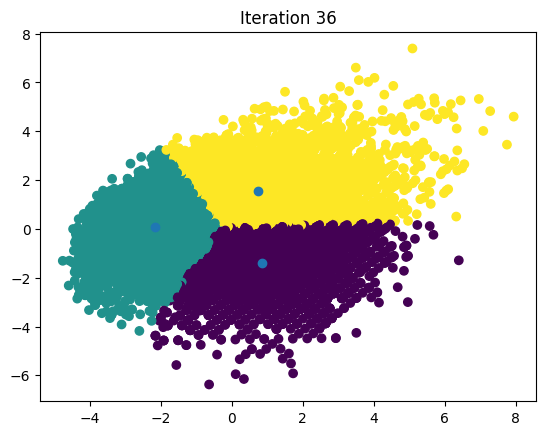

In [63]:
iterationMax = 100
k = 3
centroids = create_centroid(data,k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < iterationMax and not centroids.equals(old_centroids):
    old_centroids = centroids 
    labels = get_labels(data,centroids)
    centroids = updated_centroids(data,labels,k)
    cluster_viz(data,labels,centroids,iteration)
    iteration += 1
    


In [62]:
centroids 

,0,1,2,3,4
overall,4.324975,6.516337,4.075327,5.466359,2.521264
potential,5.872427,6.892355,3.989831,5.121871,4.430371
value_eur,1.062533,1.487391,1.026643,1.073443,1.013545
wage_eur,1.073663,1.715538,1.046160,1.208723,1.016237
age,2.688942,3.931080,4.713610,5.884316,2.309197


In [60]:
df[labels == 0][['short_name']+features]

,short_name,overall,potential,value_eur,wage_eur,age
7025,Sandeiro Leal,68,68,1400000.0,7000.0,21
8028,Narcisso Mau,67,67,1100000.0,4000.0,21
8029,Botelhinonsa,67,67,1100000.0,4000.0,21
8030,Edenildo Lagoas,67,67,1100000.0,3000.0,21
8040,Dener Rolim,67,67,1200000.0,4000.0,21
...,...,...,...,...,...,...
19234,Song Defu,47,52,70000.0,1000.0,22
19235,C. Porter,47,59,110000.0,500.0,19
19236,N. Logue,47,55,100000.0,500.0,21
19237,L. Rudden,47,60,110000.0,500.0,19
